# Text Message Analysis

### Initialization

In [ ]:
# Import necessary libraries
import string
import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Import specific functions and classes
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords, twitter_samples
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import classify, NaiveBayesClassifier, pos_tag

# Download necessary NLTK resources
nltk.download("stopwords")
nltk.download("twitter_samples")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Load dataset (National University of Singapore Corpus)
df = pd.read_csv("National University of Singapore Corpus.csv", index_col=0)

In [2]:
# Rename columns
df = df.rename(columns={"length": "Length", "country": "Country"})
df.head()

,id,Message,Length,Country,Date
0,10120,Bugis oso near wat...,21,SG,2003/4
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4
4,10124,Meet after lunch la...,22,SG,2003/4


### Preprocess Text

In [3]:
len(df)

48598

In [4]:
# Drop missing values
df = df.dropna()
len(df)

48595

In [5]:
# Create a new DataFrame with only the "Message" column
text_df = df[["Message"]].copy()
text_df["Message"] = text_df["Message"].astype(str)
text_df.head()

,Message
0,Bugis oso near wat...
1,"Go until jurong point, crazy.. Available only ..."
2,I dunno until when... Lets go learn pilates...
3,Den only weekdays got special price... Haiz......
4,Meet after lunch la...


In [6]:
# Convert messages to lowercase
text_df["Lower"] = text_df["Message"].str.lower()
text_df.head()

,Message,Lower
0,Bugis oso near wat...,bugis oso near wat...
1,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
2,I dunno until when... Lets go learn pilates...,i dunno until when... lets go learn pilates...
3,Den only weekdays got special price... Haiz......,den only weekdays got special price... haiz......
4,Meet after lunch la...,meet after lunch la...


In [7]:
# Remove punctuation
punc = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", punc))

text_df["Punc"] = text_df["Lower"].apply(remove_punctuation)
text_df.head()

,Message,Lower,Punc
0,Bugis oso near wat...,bugis oso near wat...,bugis oso near wat
1,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...
2,I dunno until when... Lets go learn pilates...,i dunno until when... lets go learn pilates...,i dunno until when lets go learn pilates
3,Den only weekdays got special price... Haiz......,den only weekdays got special price... haiz......,den only weekdays got special price haiz cant ...
4,Meet after lunch la...,meet after lunch la...,meet after lunch la


In [8]:
# Remove stopwords
stop = set(stopwords.words("english"))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

text_df["Stop"] = text_df["Punc"].apply(remove_stopwords)
text_df.head()

,Message,Lower,Punc,Stop
0,Bugis oso near wat...,bugis oso near wat...,bugis oso near wat,bugis oso near wat
1,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
2,I dunno until when... Lets go learn pilates...,i dunno until when... lets go learn pilates...,i dunno until when lets go learn pilates,dunno lets go learn pilates
3,Den only weekdays got special price... Haiz......,den only weekdays got special price... haiz......,den only weekdays got special price haiz cant ...,den weekdays got special price haiz cant eat l...
4,Meet after lunch la...,meet after lunch la...,meet after lunch la,meet lunch la


In [9]:
# Count word occurrences
count = Counter()
for text in text_df["Stop"].values:
    for word in text.split():
        count[word] += 1

# Remove frequent words
frequent = set([w for (w, c) in count.most_common(20)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in frequent])

text_df["Freq"] = text_df["Stop"].apply(remove_freqwords)
text_df.head()

,Message,Lower,Punc,Stop,Freq
0,Bugis oso near wat...,bugis oso near wat...,bugis oso near wat,bugis oso near wat,bugis oso near wat
1,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,jurong point crazy available bugis n great wor...
2,I dunno until when... Lets go learn pilates...,i dunno until when... lets go learn pilates...,i dunno until when lets go learn pilates,dunno lets go learn pilates,dunno lets learn pilates
3,Den only weekdays got special price... Haiz......,den only weekdays got special price... haiz......,den only weekdays got special price haiz cant ...,den weekdays got special price haiz cant eat l...,den weekdays special price haiz cant eat liao ...
4,Meet after lunch la...,meet after lunch la...,meet after lunch la,meet lunch la,meet lunch la


In [10]:
# Remove rare words
rare_words = 20
rare = set([w for (w, c) in count.most_common()[:-rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in rare])

text_df["Rare"] = text_df["Freq"].apply(remove_rarewords)
text_df.head()

,Message,Lower,Punc,Stop,Freq,Rare
0,Bugis oso near wat...,bugis oso near wat...,bugis oso near wat,bugis oso near wat,bugis oso near wat,bugis oso near wat
1,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,jurong point crazy available bugis n great wor...,jurong point crazy available bugis n great wor...
2,I dunno until when... Lets go learn pilates...,i dunno until when... lets go learn pilates...,i dunno until when lets go learn pilates,dunno lets go learn pilates,dunno lets learn pilates,dunno lets learn pilates
3,Den only weekdays got special price... Haiz......,den only weekdays got special price... haiz......,den only weekdays got special price haiz cant ...,den weekdays got special price haiz cant eat l...,den weekdays special price haiz cant eat liao ...,den weekdays special price haiz cant eat liao ...
4,Meet after lunch la...,meet after lunch la...,meet after lunch la,meet lunch la,meet lunch la,meet lunch la


In [11]:
# Stem words
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

text_df["Stem"] = text_df["Rare"].apply(stem_words)
text_df.head()

,Message,Lower,Punc,Stop,Freq,Rare,Stem
0,Bugis oso near wat...,bugis oso near wat...,bugis oso near wat,bugis oso near wat,bugis oso near wat,bugis oso near wat,bugi oso near wat
1,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,jurong point crazy available bugis n great wor...,jurong point crazy available bugis n great wor...,jurong point crazi avail bugi n great world la...
2,I dunno until when... Lets go learn pilates...,i dunno until when... lets go learn pilates...,i dunno until when lets go learn pilates,dunno lets go learn pilates,dunno lets learn pilates,dunno lets learn pilates,dunno let learn pilat
3,Den only weekdays got special price... Haiz......,den only weekdays got special price... haiz......,den only weekdays got special price haiz cant ...,den weekdays got special price haiz cant eat l...,den weekdays special price haiz cant eat liao ...,den weekdays special price haiz cant eat liao ...,den weekday special price haiz cant eat liao c...
4,Meet after lunch la...,meet after lunch la...,meet after lunch la,meet lunch la,meet lunch la,meet lunch la,meet lunch la


In [12]:
# Remove URLs
def remove_urls(text):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    return url_pattern.sub(r"", text)

text_df["URL"] = text_df["Stem"].apply(remove_urls)
text_df.head()

,Message,Lower,Punc,Stop,Freq,Rare,Stem,URL
0,Bugis oso near wat...,bugis oso near wat...,bugis oso near wat,bugis oso near wat,bugis oso near wat,bugis oso near wat,bugi oso near wat,bugi oso near wat
1,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,jurong point crazy available bugis n great wor...,jurong point crazy available bugis n great wor...,jurong point crazi avail bugi n great world la...,jurong point crazi avail bugi n great world la...
2,I dunno until when... Lets go learn pilates...,i dunno until when... lets go learn pilates...,i dunno until when lets go learn pilates,dunno lets go learn pilates,dunno lets learn pilates,dunno lets learn pilates,dunno let learn pilat,dunno let learn pilat
3,Den only weekdays got special price... Haiz......,den only weekdays got special price... haiz......,den only weekdays got special price haiz cant ...,den weekdays got special price haiz cant eat l...,den weekdays special price haiz cant eat liao ...,den weekdays special price haiz cant eat liao ...,den weekday special price haiz cant eat liao c...,den weekday special price haiz cant eat liao c...
4,Meet after lunch la...,meet after lunch la...,meet after lunch la,meet lunch la,meet lunch la,meet lunch la,meet lunch la,meet lunch la


In [13]:
# Remove HTML tags
def remove_html(text):
    return BeautifulSoup(text, "lxml").text

text_df["HTML"] = text_df["URL"].apply(remove_html)
text_df.head()

,Message,Lower,Punc,Stop,Freq,Rare,Stem,URL,HTML
0,Bugis oso near wat...,bugis oso near wat...,bugis oso near wat,bugis oso near wat,bugis oso near wat,bugis oso near wat,bugi oso near wat,bugi oso near wat,bugi oso near wat
1,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,jurong point crazy available bugis n great wor...,jurong point crazy available bugis n great wor...,jurong point crazi avail bugi n great world la...,jurong point crazi avail bugi n great world la...,jurong point crazi avail bugi n great world la...
2,I dunno until when... Lets go learn pilates...,i dunno until when... lets go learn pilates...,i dunno until when lets go learn pilates,dunno lets go learn pilates,dunno lets learn pilates,dunno lets learn pilates,dunno let learn pilat,dunno let learn pilat,dunno let learn pilat
3,Den only weekdays got special price... Haiz......,den only weekdays got special price... haiz......,den only weekdays got special price haiz cant ...,den weekdays got special price haiz cant eat l...,den weekdays special price haiz cant eat liao ...,den weekdays special price haiz cant eat liao ...,den weekday special price haiz cant eat liao c...,den weekday special price haiz cant eat liao c...,den weekday special price haiz cant eat liao c...
4,Meet after lunch la...,meet after lunch la...,meet after lunch la,meet lunch la,meet lunch la,meet lunch la,meet lunch la,meet lunch la,meet lunch la


In [14]:
# Add preprocessed text to the original DataFrame
df["Preprocess"] = text_df[["HTML"]].copy()

# Tokenize the preprocessed text
df["Token"] = df.apply(lambda x: nltk.word_tokenize(x["Preprocess"]), axis=1)

# Save the cleaned data to a CSV file
df.to_csv("Clean_Data.csv", header = True)
df.head()

,id,Message,Length,Country,Date,Preprocess,Token
0,10120,Bugis oso near wat...,21,SG,2003/4,bugi oso near wat,"[bugi, oso, near, wat]"
1,10121,"Go until jurong point, crazy.. Available only ...",111,SG,2003/4,jurong point crazi avail bugi n great world la...,"[jurong, point, crazi, avail, bugi, n, great, ..."
2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,dunno let learn pilat,"[dunno, let, learn, pilat]"
3,10123,Den only weekdays got special price... Haiz......,140,SG,2003/4,den weekday special price haiz cant eat liao c...,"[den, weekday, special, price, haiz, cant, eat..."
4,10124,Meet after lunch la...,22,SG,2003/4,meet lunch la,"[meet, lunch, la]"


## Data Analysis

### Visualization with Pandas, Matplotlib, and Seaborn

In [15]:
# Get unique country count and their value counts
unique_country_count = df["Country"].nunique()
country_value_counts_original = df["Country"].value_counts()
country_value_counts_original

Singapore              22013
SG                      9804
India                   6901
United States           3749
USA                     1931
Sri Lanka               1017
Malaysia                 766
Pakistan                 751
unknown                  602
Canada                   198
Bangladesh               126
China                    107
india                    105
INDIA                     79
Philippines               67
Indonesia                 48
Nepal                     39
srilanka                  30
United Kingdom            30
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Turkey                    10
Trinidad and Tobago       10
Lebanon                   10
Slovenia                  10
Nigeria                   10
New Zealand               10
Macedonia                 10
UK                        10
Morocco                    9
Romania                    9
Australia     

In [16]:
# Replace abbreviated country names with full names
df = df.replace({"Country": {"SG": "Singapore",
"USA": "United States",
"india": "India",
"INDIA": "India",
"srilanka": "Sri Lanka",
"UK": "United Kingdom",
"BARBADOS": "Barbados",
"jamaica": "Jamaica",
"MY": "Malaysia",
"unknown": "Unknown"}})

# Calculate unique country count and value counts after replacement
unique_country_count_updated = df["Country"].nunique()
country_value_counts_updated = df["Country"].value_counts()
country_value_counts_updated

Singapore              31817
India                   7085
United States           5680
Sri Lanka               1047
Malaysia                 767
Pakistan                 751
Unknown                  602
Canada                   198
Bangladesh               126
China                    107
Philippines               67
Indonesia                 48
United Kingdom            40
Nepal                     39
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Trinidad and Tobago       10
Lebanon                   10
Turkey                    10
Nigeria                   10
New Zealand               10
Slovenia                  10
Macedonia                 10
Morocco                    9
Australia                  9
Romania                    9
Jamaica                    8
Barbados                   8
Spain                      5
France                     5
Name: Country, dtype: int64

<AxesSubplot: >

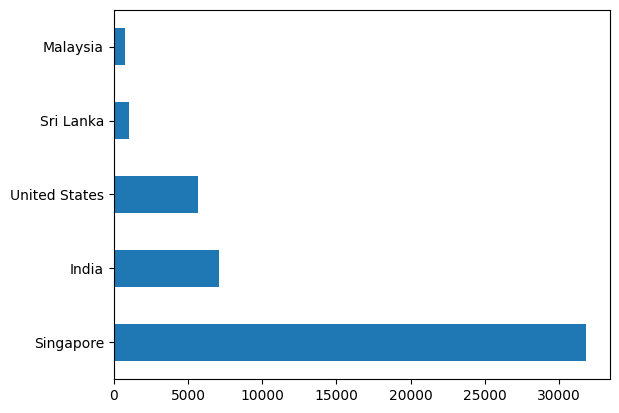

In [17]:
# Get top 5 countries with most data
top_5_countries = country_value_counts_updated.head(5)

# Plot the top 5 countries" value counts
top_5_countries.plot.barh()

### Find Commonly Used Phrases with POS Tagging

In [18]:
# Function to extract phrases based on POS tags
def find_phrases(pos_tags):
    phrases = []
    for i in range(len(pos_tags) - 1):
        # Adjective followed by a noun (JJ+NN)
        if pos_tags[i][1] == "JJ" and pos_tags[i + 1][1] == "NN":
            phrases.append(pos_tags[i][0] + " " + pos_tags[i + 1][0])
        # Adverb followed by an adjective (RB+JJ)
        elif pos_tags[i][1] == "RB" and pos_tags[i + 1][1] == "JJ":
            phrases.append(pos_tags[i][0] + " " + pos_tags[i + 1][0])
    return phrases

# Apply POS tagging to the tokenized text
df["POS"] = df["Token"].apply(nltk.pos_tag)

# Extract phrases based on specific POS tag patterns
df["Phrases"] = df["POS"].apply(find_phrases)

# Flatten the list of phrases and count the occurrences
all_phrases = [phrase for phrases in df["Phrases"] for phrase in phrases]
phrase_counts = Counter(all_phrases)

In [19]:
# Print the most common phrases
print(phrase_counts.most_common(10))

[('new year', 147), ('good night', 100), ('next week', 96), ('good morn', 90), ('good luck', 57), ('last night', 48), ('late repli', 46), ('whole day', 42), ('sweet dream', 39), ('happi new', 38)]


### Sentiment Analysis

In [20]:
# Load positive and negative tweets
positive_tweets = twitter_samples.strings("positive_tweets.json")
negative_tweets = twitter_samples.strings("negative_tweets.json")

print(positive_tweets[-1])
print(negative_tweets[-1])

print("There are {} positive tweets.".format(len(positive_tweets)))
print("There are {} negative tweets.".format(len(negative_tweets)))

@DanielOConnel18 you could say he will have egg on his face :-)
@eawoman As a Hull supporter I am expecting a misserable few weeks :-(
There are 5000 positive tweets.
There are 5000 negative tweets.


In [21]:
# Tokenize positive and negative tweets
positive_tweet_tokens = twitter_samples.tokenized("positive_tweets.json")
negative_tweet_tokens = twitter_samples.tokenized("negative_tweets.json")

print(positive_tweet_tokens[-1])
print(negative_tweet_tokens[-1])

['@DanielOConnel18', 'you', 'could', 'say', 'he', 'will', 'have', 'egg', 'on', 'his', 'face', ':-)']
['@eawoman', 'As', 'a', 'Hull', 'supporter', 'I', 'am', 'expecting', 'a', 'misserable', 'few', 'weeks', ':-(']


In [ ]:
# Clean tweets by removing URLs and HTML tags
positive_cleaned_tweets = []
negative_cleaned_tweets = []

for tweet in positive_tweet_tokens:
    cleaned_tweet = []
    for token in tweet:
        url_cleaned = remove_urls(token)
        html_cleaned = remove_html(url_cleaned)
        cleaned_tweet.append(html_cleaned)
    positive_cleaned_tweets.append(cleaned_tweet)

for tweet in negative_tweet_tokens:
    cleaned_tweet = []
    for token in tweet:
        url_cleaned = remove_urls(token)
        html_cleaned = remove_html(url_cleaned)
        cleaned_tweet.append(html_cleaned)
    negative_cleaned_tweets.append(cleaned_tweet)

In [23]:
print(positive_cleaned_tweets[:3])
print(negative_cleaned_tweets[:3])

[['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)'], ['@Lamb2ja', 'Hey', 'James', '!', 'How', 'odd', ':/', 'Please', 'call', 'our', 'Contact', 'Centre', 'on', '02392441234', 'and', 'we', 'will', 'be', 'able', 'to', 'assist', 'you', ':)', 'Many', 'thanks', '!'], ['@DespiteOfficial', 'we', 'had', 'a', 'listen', 'last', 'night', ':)', 'As', 'You', 'Bleed', 'is', 'an', 'amazing', 'track', '.', 'When', 'are', 'you', 'in', 'Scotland', '?', '!']]
[['hopeless', 'for', 'tmr', ':('], ['Everything', 'in', 'the', 'kids', 'section', 'of', 'IKEA', 'is', 'so', 'cute', '.', 'Shame', "I'm", 'nearly', '19', 'in', '2', 'months', ':('], ['@Hegelbon', 'That', 'heart', 'sliding', 'into', 'the', 'waste', 'basket', '.', ':(']]


In [24]:
# Combine positive and negative cleaned tweet lists
all_cleaned_tweets = positive_cleaned_tweets + negative_cleaned_tweets
all_tweet_tokens_combined = [token for sublist in all_cleaned_tweets for token in sublist]
len(all_tweet_tokens_combined)

130099

In [25]:
# Get most common tokens
all_tokens = nltk.FreqDist(token for token in all_tweet_tokens_combined)
sentiment_features = [word for (word, freq) in all_tokens.most_common(10000)]
sentiment_features[:5]

[':(', ':)', '!', 'I', '.']

In [26]:
# Define a function to extract features from documents
def document_features(document, sentiment_features):
    document_tokens = set(document)
    features = {}
    for token in sentiment_features:
        features[token] = (token in document_tokens)
    return features

In [27]:
# Label positive and negative tweets
positive_labeled_tweets = [(tweet, "Positive") for tweet in positive_cleaned_tweets]
negative_labeled_tweets = [(tweet, "Negative") for tweet in negative_cleaned_tweets]

# Combine labeled tweets
all_labeled_tweets = positive_labeled_tweets + negative_labeled_tweets

# Shuffle labeled tweets
random.seed(0)
random.shuffle(all_labeled_tweets)

# Create feature set from labeled tweets using document_features function
feature_set = [(document_features(document, sentiment_features), label) for (document, label) in all_labeled_tweets]

# Split the feature set into training and test sets
train_set, test_set = feature_set[:7000], feature_set[7000:]

In [28]:
# Train a Naive Bayes classifier on the training set
classifier = nltk.NaiveBayesClassifier.train(train_set)

# Calculate the accuracy of the classifier on the test set
accuracy = classify.accuracy(classifier, test_set)
print("Accuracy is:", accuracy)

# Show the 10 most informative features of the classifier
informative_features = classifier.show_most_informative_features(10)
print(informative_features)

Accuracy is: 0.9953333333333333
Most Informative Features
                      :( = True           Negati : Positi =   2078.8 : 1.0
                      :) = True           Positi : Negati =   1645.4 : 1.0
                     sad = True           Negati : Positi =     35.5 : 1.0
                     TOO = True           Negati : Positi =     24.7 : 1.0
                    miss = True           Negati : Positi =     24.7 : 1.0
                  THANKS = True           Negati : Positi =     23.4 : 1.0
                    THAT = True           Negati : Positi =     19.3 : 1.0
                   Thank = True           Positi : Negati =     17.1 : 1.0
                    Love = True           Positi : Negati =     17.0 : 1.0
                 arrived = True           Positi : Negati =     16.7 : 1.0
None


In [29]:
# Classify the sentiment of each message in the DataFrame
sentiments = []

for message in df["Token"]:
    sentiment = classifier.classify(dict([token, True] for token in message))
    sentiments.append(str(sentiment))
    
# Add sentiment classifications to the DataFrame
df["Sentiment"] = sentiments

# Calculate the value counts and normalized value counts of sentiment classifications
sentiment_value_counts = df["Sentiment"].value_counts()
sentiment_normalized_value_counts = df["Sentiment"].value_counts(normalize=True)
sentiment_normalized_value_counts

Negative    0.505505
Positive    0.494495
Name: Sentiment, dtype: float64

In [30]:
# Display the first few rows of the DataFrame
df.head()

,id,Message,Length,Country,Date,Preprocess,Token,POS,Phrases,Sentiment
0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugi oso near wat,"[bugi, oso, near, wat]","[(bugi, NN), (oso, NN), (near, IN), (wat, NN)]",[],Negative
1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,jurong point crazi avail bugi n great world la...,"[jurong, point, crazi, avail, bugi, n, great, ...","[(jurong, JJ), (point, NN), (crazi, NN), (avai...","[jurong point, n great, great world, buffet cine]",Negative
2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,dunno let learn pilat,"[dunno, let, learn, pilat]","[(dunno, JJ), (let, NN), (learn, VB), (pilat, ...",[dunno let],Positive
3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,den weekday special price haiz cant eat liao c...,"[den, weekday, special, price, haiz, cant, eat...","[(den, NN), (weekday, NN), (special, JJ), (pri...","[special price, cant eat, finish drivin]",Negative
4,10124,Meet after lunch la...,22,Singapore,2003/4,meet lunch la,"[meet, lunch, la]","[(meet, NN), (lunch, NN), (la, NN)]",[],Negative


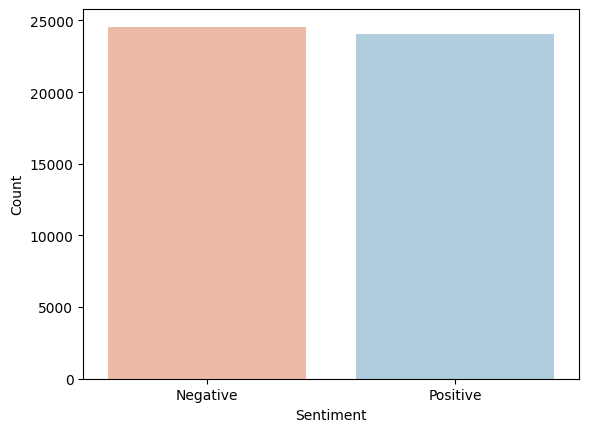

In [31]:
# Plot the sentiment value counts using seaborn
sns.countplot(x="Sentiment", data=df, palette="RdBu")
plt.ylabel("Count")
plt.show()

In [32]:
# Define a function to convert sentiment string to numerical score
def convert_sentiment(sentiment):
    if sentiment == "Positive":
        return 1
    else:
        return -1

# Add a numerical score column to the DataFrame based on sentiment
df["Score"] = df["Sentiment"].apply(convert_sentiment)

# Display the first few rows of the DataFrame with the added Score column
df.head()

,id,Message,Length,Country,Date,Preprocess,Token,POS,Phrases,Sentiment,Score
0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugi oso near wat,"[bugi, oso, near, wat]","[(bugi, NN), (oso, NN), (near, IN), (wat, NN)]",[],Negative,-1
1,10121,"Go until jurong point, crazy.. Available only ...",111,Singapore,2003/4,jurong point crazi avail bugi n great world la...,"[jurong, point, crazi, avail, bugi, n, great, ...","[(jurong, JJ), (point, NN), (crazi, NN), (avai...","[jurong point, n great, great world, buffet cine]",Negative,-1
2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,dunno let learn pilat,"[dunno, let, learn, pilat]","[(dunno, JJ), (let, NN), (learn, VB), (pilat, ...",[dunno let],Positive,1
3,10123,Den only weekdays got special price... Haiz......,140,Singapore,2003/4,den weekday special price haiz cant eat liao c...,"[den, weekday, special, price, haiz, cant, eat...","[(den, NN), (weekday, NN), (special, JJ), (pri...","[special price, cant eat, finish drivin]",Negative,-1
4,10124,Meet after lunch la...,22,Singapore,2003/4,meet lunch la,"[meet, lunch, la]","[(meet, NN), (lunch, NN), (la, NN)]",[],Negative,-1


In [ ]:
# Calculate the mean sentiment score by country
country_sentiment = df.groupby(["Country"]).mean()
country_sentiment.reset_index(inplace=True)

In [34]:
country_sentiment.head()

,Country,id,Score
0,Australia,45574.666667,-0.333333
1,Bangladesh,39876.301587,0.031746
2,Barbados,45633.500000,-0.250000
3,Canada,5763.035354,-0.141414
4,China,12499.878505,0.084112


In [35]:
# Sort the DataFrame by sentiment score in descending order
sorted_country_sentiment = country_sentiment.sort_values(by="Score", ascending=False)
sorted_country_sentiment

,Country,id,Score
28,Trinidad and Tobago,42105.500000,0.800000
17,Nepal,42863.846154,0.435897
16,Morocco,41835.777778,0.333333
20,Pakistan,6326.893475,0.259654
32,Unknown,34551.109635,0.239203
6,Ghana,41857.500000,0.222222
8,India,9255.337191,0.216090
5,France,10734.000000,0.200000
30,United Kingdom,28328.125000,0.200000
26,Spain,28325.000000,0.200000


<AxesSubplot: xlabel='Country', ylabel='Score'>

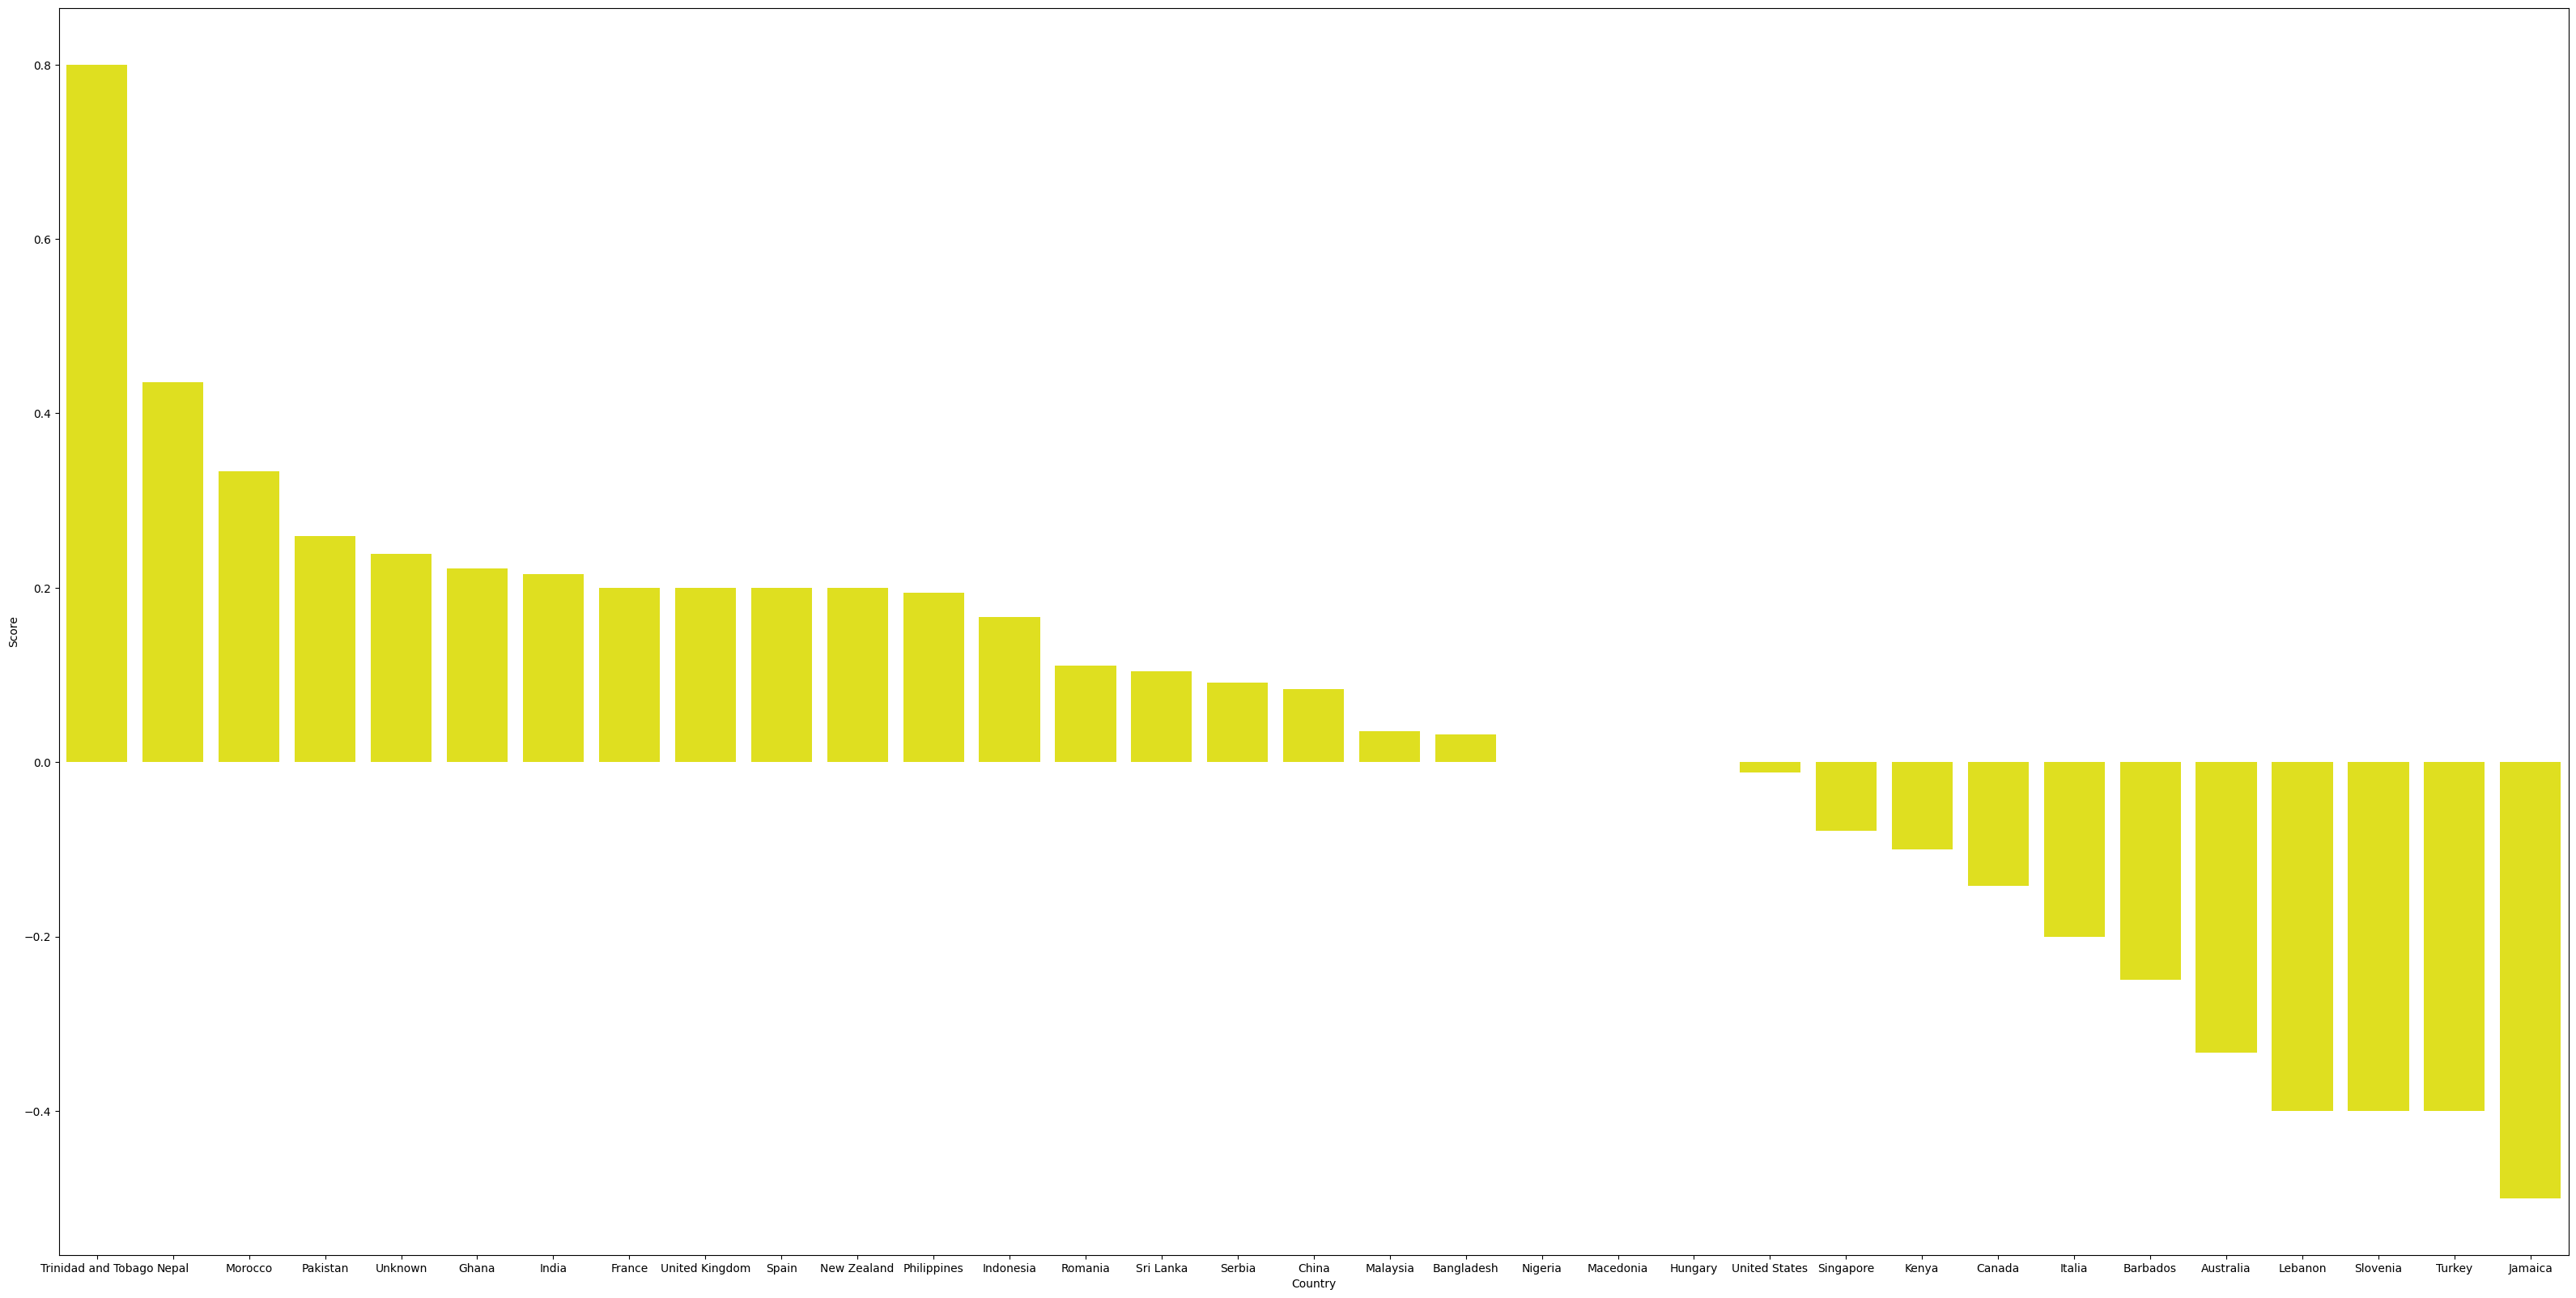

In [37]:
# Plot the sentiment scores by country using seaborn
fig, ax = plt.subplots(figsize=(40, 20))
sns.barplot(x="Country", y="Score", data=sorted_country_sentiment, ax=ax, color="yellow")